In [3]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import xarray as xr
import gsw
import velosearaptor
import yaml

import gvpy as gv

%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

Look at some attributes in one of the ADCP files.

In [4]:
tmp = xr.open_dataset("/Users/gunnar/Projects/piston-proc/data/proc/adcp/SIO1/PISTON_SIO1_SN11181.nc")

In [5]:
tmp.temperature.attrs

{'long_name': 'temperature',
 'standard_name': 'sea_water_temperature',
 'units': 'degrees_C',
 'coverage_content_type': 'physicalMeasurement',
 'ancillary_variables': 'npings'}

In [8]:
mooring = "SIO1"

- DONE: Read parameters.yml from ADCP processing.
- DONE: Add lon/lat to attributes.
- DONE: Add other standard attributes.
- DONE: Add specific attributes for temperature depth-time series.
- Save to netcdf.
- Run for both gridded datasets.

In [17]:
def load_t_and_add_meta_data(mooring):
    path_l1 = Path("/Users/gunnar/Projects/piston-proc/data/proc/thermistor/L1")
    a = xr.open_dataarray(path_l1.joinpath(f"{mooring}_Tgrid.nc"))

    a.name = "t"

    a.attrs = {
        "long_name": "temperature",
        "standard_name": "sea_water_temperature",
        "units": "degrees_C",
        "coverage_content_type": "physicalMeasurement",
    }
    a.attrs["mooring"] = mooring

    a.depth.attrs = dict(
        long_name="depth",
        standard_name="depth",
        units="m",
        positive="down",
        coverage_content_type="coordinate",
    )

    yamlfile = "../adcp/parameters.yml"
    with open(yamlfile, "r") as file:
        yp = yaml.safe_load(file)

    yp["meta_data"].pop("procesing_level")

    a.attrs["lon"] = yp["mooring"][mooring]["lon"]
    a.attrs["lat"] = yp["mooring"][mooring]["lat"]

    def add_standard_meta_data(ds):
        ds.attrs["time_coverage_start"] = np.datetime_as_string(
            ds.time.isel(time=0).data, "m"
        )
        ds.attrs["time_coverage_end"] = np.datetime_as_string(
            ds.time.isel(time=-1).data, "m"
        )
        for mm in ["min", "max"]:
            ds.attrs[f"geospatial_lon_{mm}"] = f"{ds.attrs['lon']}"
            ds.attrs[f"geospatial_lat_{mm}"] = f"{ds.attrs['lat']}"
        return ds

    a = add_standard_meta_data(a)

    yp["meta_data"]["instrument"] = "temperature logger"
    yp["meta_data"]["featureType"] = "timeSeriesProfile"
    yp["meta_data"]["processing_level"] = "Data interpolated"
    yp["meta_data"][
        "keywords"
    ] = "EARTH SCIENCE >OCEANS >OCEAN TEMPERATURE >WATER TEMPERATURE"

    for k, v in yp["meta_data"].items():
        a.attrs[k] = v
    savepath = Path("/Users/gunnar/Projects/piston-proc/data/proc/thermistor/L2")
    a.to_netcdf(savepath.joinpath(f"PISTON_{mooring}_Tgrid.nc"))
    return a

In [19]:
a = load_t_and_add_meta_data(mooring="SIO1")

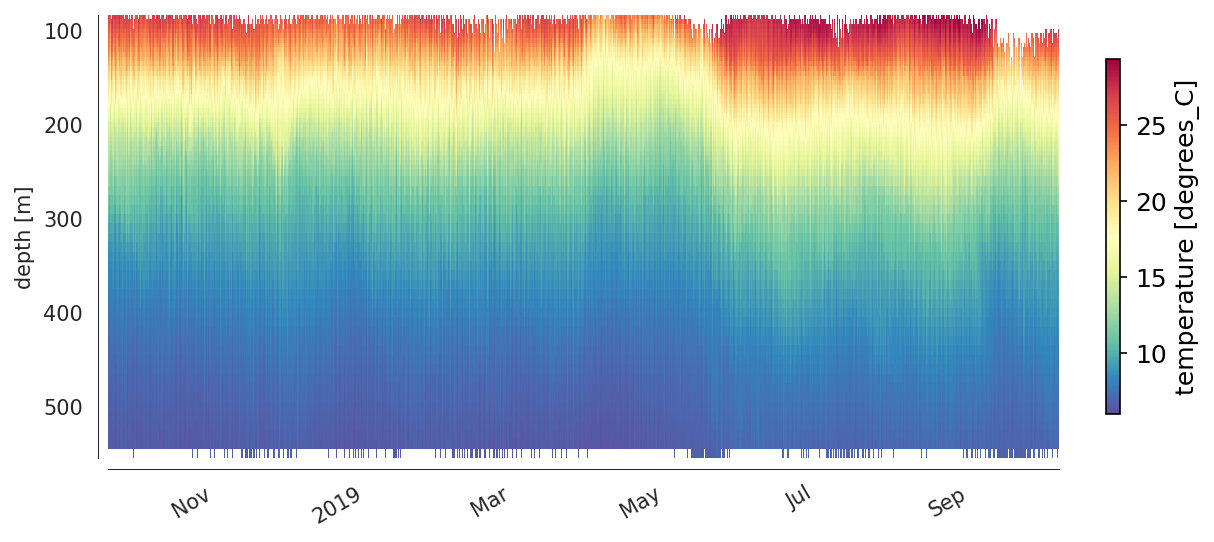

In [24]:
a.gv.plot()

In [21]:
b = load_t_and_add_meta_data(mooring="SIO3")

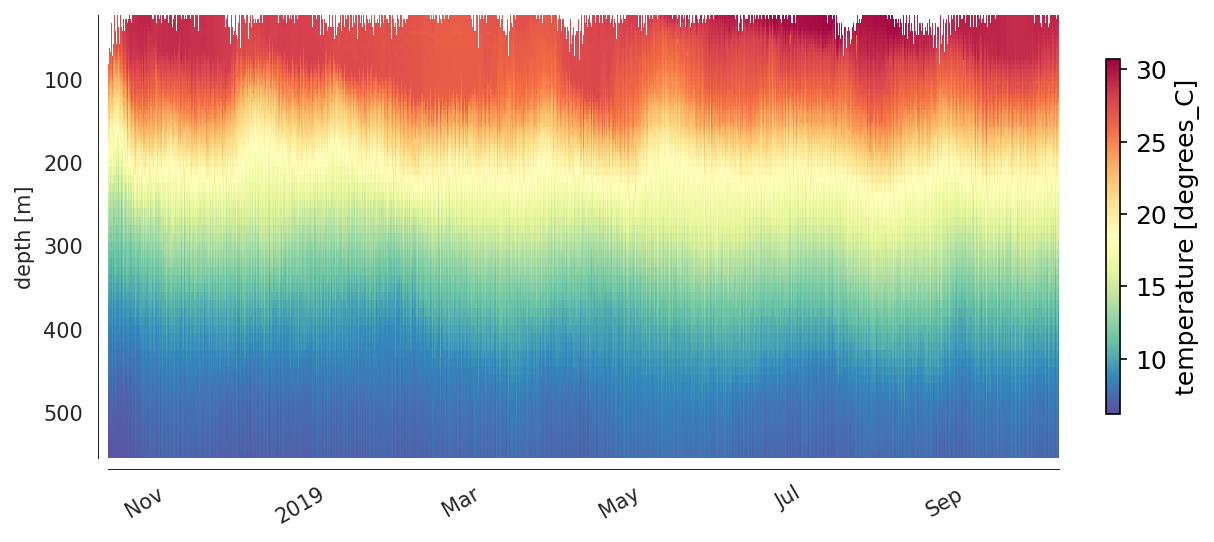

In [25]:
b.gv.plot()